# DetecTreeRGB Tiling

This notebook **loads**:
* Tiffs of RGB forest imagery
* Shapefiles of manually delineated tree crowns

This notebook **explores**:
* Tiff bounds

This notebook **does**:
* Tiling of large tiffs
* Tiling of large shapefiles
* Conversion of tiled tiff to png
* Conversion of tiled shapefile to GeoJSON
* Adjustment of these so that they align sensibly with origin (0,0) - this is tricky and still not solved properly...

Once tiled...

We can then train a Mask R-CNN model which learns how to delineate trees exactly using manual crowns as training data.

This is given in training.ipynb

Predicting with a trained model is done in predicting.ipynb





In [ ]:
# mount google drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# may need to restart kernel after this cell is 

!pip -q install pygeos

     |████████████████████████████████| 2.1 MB 10.3 MB/s 


In [ ]:
# install necessary geospatial packages

!pip -q install rasterio
!pip -q install fiona
!pip -q install geopandas
!pip -q install pycrs
!pip -q install descartes 
!pip -q install pypng

     |████████████████████████████████| 19.3 MB 1.1 MB/s 
     |████████████████████████████████| 16.7 MB 90 kB/s 
     |████████████████████████████████| 1.0 MB 7.1 MB/s 
     |████████████████████████████████| 6.3 MB 50.7 MB/s 
     |████████████████████████████████| 48 kB 3.0 MB/s 


In [ ]:
# necessary basic libraries
import pandas as pd
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
import json
import png
import glob

# geospatial libraries
import rasterio
import geopandas
from geopandas.tools import sjoin
import fiona
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs
import descartes

# import more geospatial libraries
import rasterio
from rasterio.transform import from_origin
import rasterio.features

import fiona

from shapely.geometry import shape, mapping, box
from shapely.geometry.multipolygon import MultiPolygon

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Exploration of the data

In [ ]:
### let's first read in the data.
### Firstly the tiff file of our area of interest, secondly our shapefile of manually delineated crowns, 
### if we are training the model rather than simply using a pre-trained model.

# Read in a tiff file
data = rasterio.open('gdrive/MyDrive/JamesHirst/NY/LargeArea_images/naip_hwf/naip_hwf.tif')

# Read in shapefile of crowns, if training on your own data!
#crowns = geopandas.read_file('gdrive/MyDrive/JamesHirst/NY/Buffalo/Buffalo_raw_data/all_crowns.shp')

# have a look at the crowns if we like
#crowns

shape = (23960, 17580) , BoundingBox(left=554862.0, bottom=4864962.0, right=565410.0, top=4879338.0) and number of bands = 4 ,crs = EPSG:26918


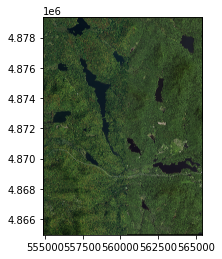

In [ ]:
# let's investigate the tiff, what is the shape? Bounds? Bands? CRS?
# show a plot of it too

print('shape =', data.shape,',', data.bounds, 'and number of bands =', data.count, ',crs =', data.crs)

# have a look if you want (usually slow)
# show(data)

In [ ]:
## find x and y origin of the tiff, need to set the north western corner as the origin 

print(data.bounds)
tiff_x_origin = data.bounds[0]
tiff_y_origin = data.bounds[1]
print('Tiff x origin:', tiff_x_origin)
print('Tiff y origin:', tiff_y_origin)

BoundingBox(left=554862.0, bottom=4864962.0, right=565410.0, top=4879338.0)
Tiff x origin: 554862.0
Tiff y origin: 4864962.0


In [ ]:
# just defining a function we are going to use shortly.

def getFeatures(gdf):
        """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
        return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [ ]:
### Read in a tiff file, and create tiles for the image
### Also read in a shapefile of manual crowns if you are wanting to train with your own crowns, if you dont
### then you will need to comment out all the lines out that involve this

tif_file =  'gdrive/MyDrive/JamesHirst/NY/LargeArea_images/naip_cayuga/naip_cayuga.tif'
# crown_file = 'gdrive/MyDrive/JamesHirst/NY/Buffalo/Buffalo_raw_data/all_crowns.shp'

data = rasterio.open(tif_file)
# crowns = geopandas.read_file(crown_file)


# set the desired buffer, tile width, height and resolution of the tiff tiles. Suggested values are given below. 
# The buffer will be affected by the area of tree crowns in your region of forest.
buffer = 20
tile_width = 200 
tile_height = 200
resolution = 0.6 # in metres per pixel - @James Ball can you get this from the tiff?
scaling = 1/resolution  # scaling parameter to transform the shapefile coordinates so they match the png

for minx in np.arange(data.bounds[0], data.bounds[2]-tile_width, tile_width, int):
    # print('minx:', minx)
    for miny in np.arange(data.bounds[1], data.bounds[3]-tile_height, tile_height, int):    
      # print('miny:', miny)

      # new tiling bbox including the buffer
      bbox = box(minx-buffer, miny-buffer, minx+tile_width+buffer, miny+tile_height+buffer)
      # define the bounding box of the tile, excluding the buffer (hence selecting just the central part of the tile)
      bbox_central = box(minx, miny, minx+tile_width, miny+tile_height)

      # turn the bounding boxes into geopandas DataFrames
      geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
      geo_central = gpd.GeoDataFrame({'geometry': bbox_central}, index=[0], crs=from_epsg(4326))   #3182
      
      ### here we are cropping the tiff to the bounding box of the tile we want
      coords = getFeatures(geo)
      #print("Coords:", coords)     
      
      # define the tile as a mask of the whole tiff with just the bounding box
      out_img, out_transform = mask(data, shapes=coords, crop=True)
      #print('out transform:', out_transform)

      ### This can be useful when reprojecting later as know the crs format to put it into
      epsg_code = int(data.crs.data['init'][5:])
      #print(epsg_code)

      # copy the metadata then update it, the "nodata" and "dtype" where important as made larger 
      # tifs have outputted tiles which were not just black
      out_meta = data.meta.copy() 
      out_meta.update({"driver": "GTiff",
                      "height": out_img.shape[1],
                      "width": out_img.shape[2],
                      "transform": out_transform,
                       "nodata": None,
                       "dtype": 'uint8'
                      })
      # print('Out Meta:',out_meta)

      ### Saving the tile as a new tiff, named by the origin of the tile. If tile appears blank in folder can show the image here and may
      ### need to fix RGB data or the dtype
      # show(out_img)
      out_tif = 'gdrive/MyDrive/JamesHirst/NY/LargeArea_images/naip_cayuga/naip_cayuga_tifs_by_me/tile_'+str(minx)+'_'+str(miny)+'.tif'
      with rasterio.open(out_tif, "w", **out_meta) as dest:
                        dest.write(out_img)
      
      # read in the tile we have just saved
      clipped = rasterio.open('gdrive/MyDrive/JamesHirst/NY/LargeArea_images/naip_cayuga/naip_cayuga_tifs_by_me/tile_'+str(minx)+'_'+str(miny)+'.tif')
      # read it as an array
      #show(clipped)
      arr = clipped.read()
      
      # each band of the tiled tiff is a colour!
      R = arr[0]
      G = arr[1]
      B = arr[2]
      
      # stack up the bands in an order appropriate for saving with cv2, then rescale to the correct 0-255 range for cv2
      
      rgb = np.dstack((B,G,R)) # BGR for cv2
      rgb_rescaled = rgb # scale to image
      #print('rgb rescaled', rgb_rescaled)
      
      # save this as jpg or png...we are going for png...again, named with the origin of the specific tile
      # here as a naughty method
      cv2.imwrite('gdrive/MyDrive/JamesHirst/NY/LargeArea_images/naip_cayuga/naip_cayuga_tiled_by_me/tile_'+str(minx)+'_'+str(miny)+'.png', rgb_rescaled)
      
      img = cv2.imread('gdrive/MyDrive/JamesHirst/NY/LargeArea_images/naip_cayuga/naip_cayuga_tiled_by_me/tile_'+str(minx)+'_'+str(miny)+'.png')
      #print('png shape:', img.shape) 


      
      ### IF HAVE MANUAL CROWNS FOR TRAINING PURPOSES UNCOMMENT ALL THE FOLLOWING LINES

      # ### now we have dealt with tiling the tiff, we want to deal with tiling the crowns...
      # ### select the crowns that intersect the non-buffered central section of the tile using the inner join
      # overlapping_crowns = sjoin(crowns, geo_central, how="inner")
      # overlapping_crowns = overlapping_crowns.explode(index_parts=True)
      # print('Overlapping crowns:', overlapping_crowns)

      # ### translate to 0,0 to overlay on png
      # # this now works as a universal approach.
      # if minx == data.bounds[0] and miny == data.bounds[1]:
      #   print('We are in the bottom left!')
      #   moved = overlapping_crowns.translate(-minx, -miny)
      # elif miny == data.bounds[1]:
      #   print('We are on the bottom, but not bottom left')
      #   moved = overlapping_crowns.translate(-minx+buffer, -miny)
      # elif minx == data.bounds[0]:
      #   print('We are along the left hand side, but not bottom left!')
      #   moved = overlapping_crowns.translate(-minx, -miny+buffer)
      # else:
      #   print('We are in the middle!')
      #   moved = overlapping_crowns.translate(-minx+buffer, -miny+buffer)
      # print("Moved coords:", moved)

  
      # ### scale to deal with the resolution
      # moved_scaled = moved.scale(scaling, scaling, origin=(0, 0)) 
      # #print(moved_scaled)

      # ### save as a geojson, a format compatible with detectron2, again named by the origin of the tile.
      # ### If the box selected from the image is outside of the mapped region due to the image being on a slant 
      # ### then the shp file will have no info on the crowns and hence will create an empty gpd Dataframe.
      # ### this causes an error so skip creating geojson. The training code will also ignore png so no problem.
      # try:
      #   moved_scaled.to_file(driver = 'GeoJSON', 
      #                            filename= 'gdrive/MyDrive/JamesHirst/NY/Buffalo/Buffalo_train/tile_'+str(minx)+'_'+str(miny)+'.geojson')
      # except:
      #   print('ValueError: Cannot write empty DataFrame to file.')  

      
          
      
      

minx: 361698
miny: 4734036
26918
miny: 4734236
26918
miny: 4734436


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axi

26918
miny: 4734636
26918
miny: 4734836
26918
miny: 4735036
26918
miny: 4735236


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axi

26918
miny: 4735436
26918
miny: 4735636
26918
miny: 4735836
26918
miny: 4736036


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axi

26918
miny: 4736236
26918
miny: 4736436
26918
miny: 4736636
26918
miny: 4736836


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axi

26918
miny: 4737036
26918
miny: 4737236
26918
miny: 4737436
26918
miny: 4737636


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axi

26918
miny: 4737836
26918
miny: 4738036
26918
miny: 4738236


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axi

26918
miny: 4738436
26918
miny: 4738636
26918
miny: 4738836


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axi

26918
miny: 4739036
26918
miny: 4739236
26918
miny: 4739436


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axi

26918
miny: 4739636
26918
miny: 4739836
26918
miny: 4740036


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axi

26918
miny: 4740236
26918
miny: 4740436
26918
miny: 4740636


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axi

26918
miny: 4740836
26918
miny: 4741036
26918
miny: 4741236


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axi

26918
miny: 4741436
26918
miny: 4741636


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axi

26918
miny: 4741836
26918
miny: 4742036
26918
miny: 4742236


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axi

26918
miny: 4742436
26918
miny: 4742636
26918
miny: 4742836


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axi

26918
miny: 4743036
26918
miny: 4743236
26918
miny: 4743436


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axi

26918
miny: 4743636
26918
miny: 4743836


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axi

26918
miny: 4744036
26918
miny: 4744236
26918
miny: 4744436


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axi

26918
miny: 4744636
26918
miny: 4744836


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axi

26918
miny: 4745036
26918
miny: 4745236
26918
miny: 4745436


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axi

26918
miny: 4745636
26918
miny: 4745836
26918
miny: 4746036


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axi

26918
miny: 4746236
26918
miny: 4746436


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axi

26918
miny: 4746636
26918
miny: 4746836
26918
miny: 4747036


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axi

26918
miny: 4747236
26918
miny: 4747436


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axi

26918
miny: 4747636
26918
miny: 4747836
26918
miny: 4748036


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


KeyboardInterrupt: ignored